# 11. 프로젝트: 뉴스기사 요약해보기
## 학습목표
- Extractive/Abstractive summarization 이해하기
- 단어장 크기를 줄이는 다양한 text normalization 적용해보기
- seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기

-> 뉴스 기사를 추상적 요약/추출적 요약을 통해 요약한다. 

## 이론
####  텍스트 요약(Text Summarization)    
긴 길이의 문서(Document) 원문을 핵심 주제만으로 구성된 짧은 요약(Summary) 문장들로 변환하는 것이다. 텍스트 요약의 핵심은 요약 전후에 정보 손실 발생이 최소화 되어야 한다는 것이다. 
#### 텍스트 요약의 종류
크게 추출적 요약(Extractive Summarization)과 추상적 요약(Abstractive Summarization)로 이루어져 있다. 

- 추출적 요약   
원문에서 문장들을 추출해서 요약 하는 방식이다. 전통적인 머신 러닝 방식에 속하는 텍스트랭크(TextRank)와 같은 알고리즘을 사용하며, 문장이 어색할 수도 있다. 예: 네이버 뉴스 요약봇

- 추상적 요약    
원문으로부터 내용이 요약된 새로운 문장을 생성하는 방식으로, 자연어 생성(Natural Language Generation, NLG)의 영역이며, 문장 분류(Text Classification) 문제로 볼 수 있다.

#### 추상적 요약에 대해 알아야 할 것
1. seq2seq(sequence-to-sequence)     
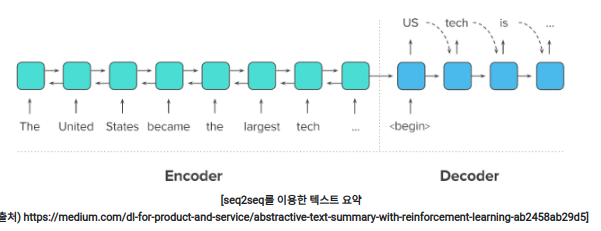 

seq2seq은 두 개의 RNN 아키텍처를 사용하여 입력 시퀀스로부터 출력 시퀀스를 생성해내는 자연어 생성 모델이나 이번 프로젝트에서는 LSTM을 사용한다. (참고: [LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/))   
LSTM은 다음 time step의 셀에 __hidden stater과 함께 cell state__ 도 전달한다. 따라서 인코더가 디코더에 전달하는 컨텍스트 벡터(context vector, 문맥 정보를 가지고 있는 벡터) 또한 hidden state h와 cell state c 모두 존재해야 한다.

2. 시작 토큰(SOS)과 종료 토큰(EOS)      
seq2seq 구조에서 디코더는 시작 토큰 SOS가 입력되면, 각 시점마다 단어를 생성하는 과정을 종료 토큰 EOS를 예측하는 순간까지 멈추지 않기 때문에 훈련 데이터의 예측 대상 시퀀스의 앞, 뒤에는 시작 토큰과 종료 토큰을 넣어주어야 한다(전처리 과정).     


3. 어텐션 메커니즘
![](https://images.velog.io/images/guide333/post/ef241ebf-7590-4882-9351-e8857f3b33df/Screenshot%20from%202021-02-18%2010-20-45.png)

어텐션 메커니즘(Attention Mechanism)은 __인코더의 모든 step의 hidden state의 정보가 컨텍스트 벡터에 전부 반영__ 되도록 한다. 인코더의 모든 hidden state는 __디코더의 현재 time step의 예측에 인코더의 각 step이 얼마나 영향을 미치는지에 따른 가중합__ 으로 계산된다. 

주의할 것은 컨텍스트 벡터를 구성하기 위한 인코더 hidden state의 가중치 값은 __디코더의 현재 스텝이 어디냐__ 에 따라 계속 달라진다는 것이다. 디코더의 현재 문장 생성 부위(주어, 술어, 목적어 등)에 따라 인코더가 컨텍스트 벡터가 다른 값이 된다. 

#### 추상적 요약 순서
1. seq2seq 사용
2. RNN 계열 중 LSTM을 사용하므로 hidden state와 cell state을 함께 사용
3. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙인다.
4. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측 시작
5. 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산
6. 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측

- 참고 영상 : [08-1: Seq2Seq Learning (Kor)](https://www.youtube.com/watch?v=0lgWzluKq1k)

## 프로젝트 순서 
1. 데이터 수집        
2. 데이터 전처리(추상적 요약)      
   1) 중복 샘플과 Null값 샘플 제거      
   2) 텍스트 정규화      
   3) 불용어 제거     
   4) 샘플의 최대 길이 정하기
   5) 시작 토큰과 종료 토큰 추가      
   6) 훈련데이터와 테스트 데이터 나누기    
   7) 단어 집합 만들기     
   8) 정수 인코딩     
   9) 패딩    
3. 추상적 요약 모델 설계        
   1) 인코더와 디코더 설계       
   2) 어텐션 매커니즘 사용      
4. 추상적 요약 모델 훈련      
5. 인퍼런스 모델 구현       
   정수 인코딩한 데이터를 실제 데이터로 복원          
6. 추상적 요약 모델 테스트(실제 결과와 요약문 비교)  
7. 추출적 요약       

## Step 1. 데이터 수집하기
[뉴스 기사 데이터(newssummarymore.csv)](https://github.com/sunnysai12345/News_Summary)를 다운로드한다.

In [1]:
# 필요한 라이브러리/패키지 불러오기
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj44/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Duplicate key in file PosixPath('/home/aiffel-dj44/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 251 ('font.family:  sans-serif')


In [2]:
# 뉴스 데이터 다운로드
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data1 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

# 랜덤한 10개 샘플 출력
data.sample(10)

,headlines,text
27502,Cracks in another Mumbai bridge after overbrid...,The Mumbai Police on Wednesday tweeted a warni...
11787,Is a sex worker who sells her body to feed chi...,Responding to people trolling her for a pictur...
47293,South African women's team beats India by 5 wi...,The Indian women's cricket team lost to South ...
72738,Amitabh Bachchan trolled for his tweet during ...,Amitabh Bachchan was trolled for his tweet dur...
3227,US venture capitalist served summons via Twitter,"US venture capitalist Jonathan Teo, who has be..."
19630,Authorities once broke Dhyan Chand's hockey to...,Hockey authorities in the Netherlands once bro...
37278,Argentina team cried like girls in 0-3 loss: C...,Croatian defender Sime Vrsaljko said he saw Li...
12846,Bodies of 4 siblings found in Faridabad home 3...,Bodies of three sisters and a brother were fou...
50351,Felt like a vagina after watching 'Padmaavat':...,Actress Swara Bhasker has written an open lett...
83456,Serena will be 700 in world on men's circuit: ...,Former world number one and seven-time Grand S...


In [3]:
# 샘플 수 확인
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401


다운로드받은 뉴스 데이터는 총 98401개의 샘플을 가지고 있고, 기사의 본문인 text와 제목 headlines 두 가지 열로 구성되어 있다. text를 본문, headlines를 이미 요약된 데이터로 생각하고 추상적 모델을 학습할 것이다. 

## Step 2. 데이터 전처리 (추상적 요약)
### 1) 중복 샘플과 Null값 샘플 제거
데이터의 중복 샘플이 있는지 확인해 본다.

In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


headlines의 경우는 요약된 데이터이므로 중복될 수도 있다. 그러나 text의 겅우는 중복 샘플이므로 제거한다. 

In [5]:
# 중복 샘플 제거
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


이제 Null값이 있는지 확인해 본다. 

In [6]:
# Null 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


Null값이 없으므로 앞으로 사용할 데이터의 샘플은 98360개이다. 

### 2) 텍스트 정규화
샘플에는 수많은 단어가 있고 그 중 같은 의미인데, 다른 표현으로 쓰인 단어들이 있다. 그 중 한 예는 축약어이다. 같은 표현이지만 다른 표현으로 쓰인 단어를 통일시키는 것이 텍스트 정규화(text normalization)라고 하며, 이를 위해 사전을 미리 만들어 놓는다. 

[정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [7]:
# 텍스트 정규화(text normalization) 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


### 3) 불용어 제거
텍스트에는 자주 등장하지만 자연어 처리를 할 때 도움이 되지 않는 단어를 불용어(stopwords)라고 한다. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법이다. NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거한다. 

In [8]:
# 불용어 파악
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개이다. 이를 사용해 1) 불용어를 제거하고, 모든 영어문자는 2) 소문자로 만들고, 섞여있는 3) html 태그를 제거하고, 정규 표현식을 통해 4) 각종 특수문자를 제거한다. 그러나 상대적으로 문장 길이가 짧은 headlines을 전처리할 때는 불용어를 제거하지 않는다.

In [9]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 
    sentence = re.sub('"','', sentence) # 따옴표 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. 
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경
    # sentence = re.sub('[i]{1,}', 'i', sentence) # m이 3개 이상이면 2개로 변경
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

함수가 제대로 만들어졌는지 간단한 예제로 확인해 본다. 

In [10]:
# 예제로 함수 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headline = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headline, False))  # 불용어를 제거하지 않음

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


text와 headlines에 대해 데이터 전처리를 하고 확인해 본다. headlines의 경우는 불용어를 제거하지 않으므로 함수의 두 번째 인자에 False를 넣어준다. 

In [11]:
# 훈련 데이터 전처리
clean_text = []

# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [12]:
# summary전처리
clean_headlines = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

데이터 정제를 마친 후 보기 쉽게 데이터를 테이터프레임에 저장하고, 빈 샘플이 있다면 Null값으로 대체한다. 

In [13]:
# 데이터를 데이터프레임에 저장
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)  

- ```data.replace('', np.nan, inplace=True)```     
''를 null로 변환한다. np.nan: 숫자가 아닌 것, inplace=True: 원본 데이터를 바꾼다. (참고: https://ponyozzang.tistory.com/613)

In [14]:
# Null 값 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

Null값인 데이터가 없다.  

### 4) 샘플의 최대 길이 정하기
훈련에 사옹할 샘플의 최대 길이를 정해야 한다. 이를 위해 text, headlines의 최소, 최대, 평균 길이를 구하고 이를 시각화한다. 

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


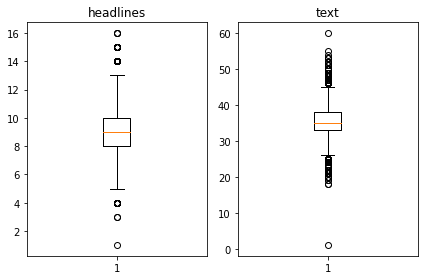

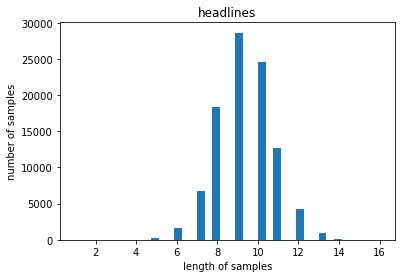

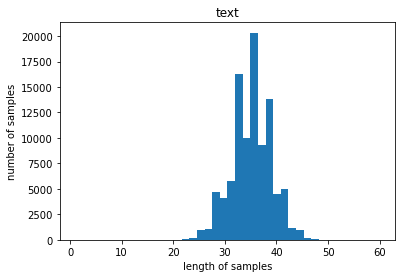

In [15]:
# text와 headlines의 최소, 최대, 평균 길이를 구하기
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

# 길이 분포 시각화
plt.subplot(1,2,1)

plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위부터 차례대로 그래프는 각각 요약과 실제 텍스트의 길이 분포, 요약본 샘플 길이별 갯수, 실제 텍스트 샘플 길이별 갯수를 나타낸다. text의 경우는 최소 길이가 1, 최대 길이가 60, 평균은 35이며 대체적으로 25-45 사이의 길이를 가진다. headlines의 경우, 최소 길이가 1, 최대 길이가 16, 평균 길이는 9이며, 대체적으로 8-11 사이의 길이를 가진다. 이 분포를 참고로 하여 text와 headlines의 적절한 최대 길이를 임의로 정한다. 

In [16]:
# 문장 최대 길이 정하기
text_max_len = 45
headlines_max_len = 12

얼마나 많은 샘플을 자르지 않고 포함하는지 통계로 확인할 수 있는 함수를 만들어 확인한다. 

In [17]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


각각 40과 11로 패딩을 하면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, text 열의 경우에는 약 8%의 샘플, headlines 열의 경우는 약 6%의 내용이 손상된다고 한다. 이제 데이터를 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제한다. 

In [18]:
# 정해진 길이보다 길면 제외한다.

data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 97183


### 5) 시작 토큰과 종료 토큰 추가
seq2seq 훈련을 위해서 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가해야 한다. 시작 토큰을 'sostoken', 종료 토큰을 'eostoken'이라고 하고, 앞, 뒤로 추가한다. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 부른다. 두 개의 문장 모두 headlines 열로부터 만든다. 

In [19]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장한다.

In [20]:
# Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 6) 훈련데이터와 테스트 데이터 나누기
직접 코딩하여 훈련데이터와 테스트 데이터로 나눈다. 우선 encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만든다.

In [21]:
print(encoder_input.shape)

(97183,)


- 참고: numpy 모듈의 arange 함수는 반열린구간 [start, stop) 에서 step 의 크기만큼 일정하게 떨어져 있는 숫자들을 array 형태로 반환해 주는 함수이다.        
출처: [코딩 연습](https://codepractice.tistory.com/88)

In [22]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[77563 23597 54278 ... 58005 62656 28040]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해주어 샘플을 잘 섞는다. (랜덤)

In [23]:
# 데이터의 샘플 순서를 정의 -> 잘 섞인 샘플
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리한다. 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의한 후, 미리 정의한 테스트 데이터의 갯수를 이용해 데이터를 나눈다.

In [24]:
# 테스트 데이터의 크기를 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19436


In [25]:
# 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 77747
훈련 레이블의 개수 : 77747
테스트 데이터의 개수 : 19436
테스트 레이블의 개수 : 19436


### 7) 단어 집합 만들기
기계가 텍스트를 숫자로 처리할 수 있도록 단어를 정수로 바꾸어야 한다. 이를 위해 각 단어에 고유한 정수를 맵핑하는 작업이 필요한데, 이 과정을 단어 집합(vocaburary)을 만든다고 한다. Keras의 토크나이저를 사용해 입력된 훈련 데이터로부터 단어 집합을 만든다. 

참고: <https://codetorial.net/tensorflow/natural_language_processing_in_tensorflow_01.html>         
>Tokenizer는 문장으로부터 단어를 토큰화하고 숫자에 대응시키는 딕셔너리를 사용할 수 있도록 한다. fit_on_texts() 메서드는 문자 데이터를 입력받아서 리스트의 형태로 변환한다. 

In [26]:
# 훈련 데이터로부터 단어 집합 만들기
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다. 생성된 단어 집합은 src_tokenizer.word_index에 저장되어있다. 만들어진 단어 집합에서 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행할 것이다. 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 어떤 비중을 차지하는지 확인한다. 

In [27]:
# 등장 빈도수가 7회 미만인 단어의 비중 확인
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69342
등장 빈도가 6번 이하인 희귀 단어의 수: 47294
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22048
단어 집합에서 희귀 단어의 비율: 68.2039745031871
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.508153675051615


등장 빈도가 threshold 값인 6회 이하인 단어들은 단어 집합에서 약 68%이지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 3.8%이다. 그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거할 것이다. 

In [28]:
src_vocab = 21500
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 21500으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

### 8) 정수 인코딩
texts_to_sequences()을 통해 단어 집합을 정수 인코딩한다.

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[8, 57, 1, 4447, 490, 14209, 109, 258, 165, 6532, 5442, 487, 8, 1, 697, 268, 277, 1385, 18, 268, 14210, 4447, 1423, 60, 4447, 2146, 389, 1302, 697, 268, 277, 3313, 4447, 1226], [960, 5544, 934, 52, 1937, 1084, 13744, 20579, 58, 960, 69, 13744, 655, 1771, 1338, 3052, 2402, 1315, 156, 1386, 1085, 411, 215, 957, 960], [11, 1429, 325, 4158, 9581, 11214, 1803, 1081, 15, 6606, 48, 4419, 9775, 1795, 880, 1547, 1201, 1699, 2465, 1037, 6, 748, 360, 1555, 11214, 2023, 929, 81, 12889, 880, 326, 1223, 1429, 9085, 930, 3768, 553]]


headlines에서도 같은 작업을 한다.

In [30]:
# headlines 데이터에 대해서도 동일한 작업
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [31]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29996
등장 빈도가 5번 이하인 희귀 단어의 수: 19674
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10322
단어 집합에서 희귀 단어의 비율: 65.58874516602214
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.735448342273346


In [32]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 5172, 3389, 279, 398, 14, 32, 1107, 23], [1, 5597, 2618, 1355, 5, 4103, 432, 13], [1, 5598, 131, 947, 72, 3, 122, 13, 2502, 374], [1, 87, 8, 4970, 6, 22, 39, 126, 4104, 1679, 48, 1881, 113], [1, 2949, 891, 1340, 313, 2048, 6, 54, 4, 61]]
target
decoder  [[5172, 3389, 279, 398, 14, 32, 1107, 23, 2], [5597, 2618, 1355, 5, 4103, 432, 13, 2], [5598, 131, 947, 72, 3, 122, 13, 2502, 374, 2], [87, 8, 4970, 6, 22, 39, 126, 4104, 1679, 48, 1881, 113, 2], [2949, 891, 1340, 313, 2048, 6, 54, 4, 61, 2]]


전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 수도 있다는 뜻이다. 이 현상은 길이가 짧은 headlines에서 발생할 것이다. 따라서 요약문에서 길이가 0이 된 샘플들의 인덱스를 찾아본다. 주의할 점은 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 단어 집합 제한에도 삭제 되지 않는다는 것이다. 따라서 길이가 0이 된 요약문의 실제길이는 1이므로 요약문의 길이가 1인 샘플들을 모두 삭제한다. 

In [33]:
# 요약문에서 길이가 0인 샘플 인덱스 받기(sostoken 또는 eostoken이 추가되었으므로 실제 길이는 1)
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


삭제할 데이터가 없다. 

### 9) 패딩
서로 다른 길이의 샘플들을 병렬 처리하기 위해 최대 길이로 맞춰준다.

In [34]:
# 최대길이로 제로 패딩(샘플을 같은 길이로 맞춰주기)
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## 3. 추상적 요약 모델 설계
### 1) 인코더와 디코더 설계
함수형 API를 이용해서 인코더를 설계한다.

In [35]:
# 함수형 API를 이용해서 인코더를 설계
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)  # 단어집합 넣기

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했다. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터이다.  인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였다.

이제 디코더를 설계한다.

In [36]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하나 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어야 한다.

다음은 디코더의 출력층을 설계한다.

In [37]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2752000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 하므로 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용한다.

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq였다. 이제 어텐션 메커니즘을 사용하여 성능을 높여본다.

### 2) 어텐션 매커니즘 사용
어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계하는 것과 같다. 지금은 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 볼 것이다. 아래의 함수로 어텐션 함수를 다운로드한다.

In [38]:
# 어텐션 함수 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

경로에 attention.py 파일이 생겼다. 이제 설계한 디코더의 출력층을 수정한다.

In [39]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2752000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용한다.

## 4. 추상적 요약 모델 훈련
EarlyStopping은 '조기 종료'의 뜻을 가지고 있고, 특정 조건이 충족되면 모델의 훈련을 멈추는 역할을 한다. val_loss(검증 데이터의 손실)을 모니터링 하면서, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 patiensce =2회 관측되면 학습을 멈추도록 설정되어져 있다. 

In [40]:
# 훈련
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
304/304 [==============================] - 110s 361ms/step - loss: 5.6086 - val_loss: 5.1717
Epoch 2/50
304/304 [==============================] - 108s 357ms/step - loss: 5.0283 - val_loss: 4.8058
Epoch 3/50
304/304 [==============================] - 109s 359ms/step - loss: 4.6731 - val_loss: 4.5123
Epoch 4/50
304/304 [==============================] - 109s 358ms/step - loss: 4.4077 - val_loss: 4.3258
Epoch 5/50
304/304 [==============================] - 108s 356ms/step - loss: 4.2017 - val_loss: 4.1946
Epoch 6/50
304/304 [==============================] - 109s 360ms/step - loss: 4.0339 - val_loss: 4.0778
Epoch 7/50
304/304 [==============================] - 110s 361ms/step - loss: 3.8872 - val_loss: 3.9875
Epoch 8/50
304/304 [==============================] - 109s 358ms/step - loss: 3.7607 - val_loss: 3.9023
Epoch 9/50
304/304 [==============================] - 109s 357ms/step - loss: 3.6527 - val_loss: 3.8446
Epoch 10/50
304/304 [==============================] - 109s 358m

손실 함수를 그려 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 살펴본다.

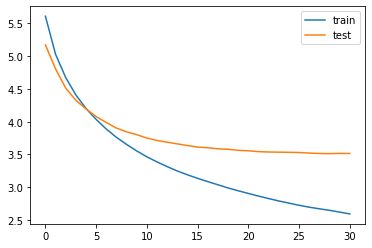

In [41]:
# 손실함수 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 5. 인퍼런스 모델 구현
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 준비한다.

In [42]:
# 정수 인덱스 행렬을 실제 데이터로 복원하기 위한 3개 사전 준비
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다. 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했지만 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다. 이때, 인코더 모델과 디코더 모델을 분리해서 설계한다.

In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계한다.

In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

단어 시퀀스를 완성하는 함수를 만든다.

In [45]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 6. 추상적 요약 모델 테스트(실제 결과와 요약문 비교)
테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하다. 따라서 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만든다. 함수를 만들 때, text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외시키고 headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외시킨다.

In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교한다.

In [47]:
for i in range(50, 100):
    print(i+1)
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

51
원문 : marc said delighted facebook post meeting late actor roger moore known playing james bond films first met moore next time unicef project moore featured campaign 
실제 요약 : at as was at fan on meeting late bond star 
예측 요약 :  creator to launch his own honour for


52
원문 : bombay high court dismissed fir actor ex bigg boss contestant armaan kohli arrested mumbai police allegedly assaulting live partner neeru randhawa submitted affidavit jail expressing regret assaulting girlfriend neeru quashing fir wish take case forward 
실제 요약 : bombay high court dismisses fir against armaan kohli 
예측 요약 :  kapil sharma gets married to girlfriend arrested


53
원문 : bbc reporter non identical twin brother duped hsbc voice recognition security system week gain access bank account users simply required say voice password verify identity reporter brother got access eighth try hsbc later said modify system allow three attempts 
실제 요약 : hsbc voice recognition system duped by customer brother 
예측 요약 :  

예측 요약 :  pune tops cities best cities in cities


74
원문 : filmmaker anurag kashyap sports drama opening film th mumbai film festival thursday dying see everybody reacts tried make film radar said kashyap film screening kunal kapoor aditi rao hydari hosted opening ceremony fest ends october 
실제 요약 : anurag kashyap opens th film festival 
예측 요약 :  anurag kashyap to be screened at mumbai film fest


75
원문 : according reports driverless car seen virginia us last week driven man disguised car seat man reportedly spotted wearing black disguise holding steering wheel later confirmed part research virginia tech transportation institute wore outfit minimise visibility 
실제 요약 : driverless car in virginia driven by man hidden in car seat 
예측 요약 :  car crashes into car to be stolen from us car


76
원문 : ali fazal starrer hollywood film victoria abdul released friday shameful attempt normalise evil wrote hindustan times ndtv wrote colonial oppression beyond film firstpost called missed opportunity 

예측 요약 :  yr old dies after falling into ambulance in delhi


97
원문 : restaurant australian city adelaide slammed hanging cow upside ceiling nearly people signing online petition restaurant serves dairy meat products designed resemble however owners said installation aims draw connection true consuming dairy 
실제 요약 : aus eatery slammed for hanging cow upside down 
예측 요약 :  australian eatery serves food to save cow


98
원문 : bloomberg reporter revealed officials pentagon us federal emergency management agency mistakenly added internal list last month emails talked presentation puerto rico recovery efforts media reflected federal government struggle convince public response effort going well 
실제 요약 : pentagon mistakenly adds reporter to internal list 
예측 요약 :  us state secy hit us east trade agency


99
원문 : many applications filed russia election commission country presidential elections march year russian citizens may contest presidential election either party candidates vladimir putin 

## 7. 추출적 요약
이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 시도해본다.

In [48]:
import requests
from summa.summarizer import summarize

- Summa의 summarize()의 인자로 사용되는 값

  - text (str) : 요약할 테스트.
  - ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
  - words (int or None, optional) – 출력에 포함할 단어 수.

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 하기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다. ratio의 경우, 작게 하면 추출적 요약이 되지 않는 문장이 많았다. 샘플의 길이나 단어 사전의 크기를 다르게 했을 때 ratio=0.3로 하면 50개의 원문 중 30개가 추출적 요약으로 나오지 않았다. 그래서 이번에는 ratio=0.4로 했더니 추출적 요약의 길이가 생각보다 길게 나왔다. 

In [58]:
# 원문에서 선택되는 문장의 비율 0.4%
for i in range(50, 100):
    print(i+1)
    print("원문 :", data1['text'][i])
    print("실제 요약 :", data1['headlines'][i])
    print("추출적 예측 요약 :", summarize(data1['text'][i], ratio=0.4))
    print("\n")

51
원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
추출적 예측 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


52
원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the sevent

### 실제 요약과 추상적 요약 비교
모든 문장을 다 비교할 수 없어서 5개의 샘플을 뽑아 비교해 보았다. 

55
원문 : least people killed fire broke hotel chinese city saturday officials said took firefighters three hours extinguish blaze hot springs leisure hotel fire reportedly broke kitchen hotel second floor

실제 요약 : killed in fire at hotel in china       
예측 요약 :  killed injured in fire at hotel in china   

65
원문 : government approved filing chargesheet samajwadi party leader azam khan year allegedly claimed women terrorists chopping private parts army personnel send strong message leave entire nation ashamed following four people including son bjp leader filed complaints khan 

실제 요약 : sp leader azam khan to be for anti army remark        
예측 요약 :  azam khan claims army khan to armed forces

75
원문 : according reports driverless car seen virginia us last week driven man disguised car seat man reportedly spotted wearing black disguise holding steering wheel later confirmed part research virginia tech transportation institute wore outfit minimise visibility 

실제 요약 : driverless car in virginia driven by man hidden in car seat   
예측 요약 :  car crashes into car to be stolen from us car

85
원문 : tickets boxing match former boxing champion floyd mayweather ufc champion conor mcgregor sold arena around lakh tickets august fight also sold online platforms notably mayweather retired record end month long retirement fight mcgregor   

실제 요약 : mayweather mcgregor fight tickets being sold for lakh    
예측 요약 :  mayweather offers lakh to buy cryptocurrency for lakh

95
원문 : militant group taliban increased amount territory influence control afghanistan past six months according report us special inspector general afghanistan reconstruction august districts afghanistan control influence compared february     
실제 요약 : taliban increasing control over afghan territory us monitor

예측 요약 :  taliban to afghanistan afghanistan 

대부분의 추상적 예측 문장은 문법이 맞지 않는다. 예를 들어 55번 문장에서 동사가 2개('killed, injured')가 들어가 있거나 95번 문장에서 동사가 없는 등 문법적으로 정확하지 않는 문장이 대다수이다. 75번이나 85번처럼 문법이 비슷하게 맞는 경우도 있지만 해석을 해보면 의미가 없거나 원문/실제 요약과 다른 경우가 있었다.           
핵심 단어의 측면에서 보면 추상적 예측 문장에 비교적 핵심 단어가 많이 들어가 있다. 55번처럼 핵심 단어인 'killed, in fire, at hotel in china'가 들어가 있는 문장들이 눈에 띄인다. 그러나 75번, 85처럼 원문에 없는 단어를 사용하고 해석도 다르게 예측한 경우도 있었다. 95번처럼 핵심 단어 중 몇 개만 나열한 것처럼 보이는 경우도 있다. 

슬랙에 올라온 정보를 토대로 텍스트 요약 모델의 성능 지표를 시도해 보았다. 파이썬 패키지인 pyrouge를 사용하려고 하였으나 우분투에서는 설치가 되지 않았다. (우분투 설치 자료: [stckoverflow](https://stackoverflow.com/questions/45894212/installing-pyrouge-gets-error-in-ubuntu), [How To Install Rouge (pyrouge) in Ubuntu 16.04](https://sagor-sarker.medium.com/how-to-install-rouge-pyrouge-in-ubuntu-16-04-7f0ec1cda81b))

코드는 [PyRouge](https://github.com/pcyin/PyRouge) 참고

[예시를 통한 ROUGE 성능 지표의 이해](https://huffon.github.io/2019/12/07/rouge/) 


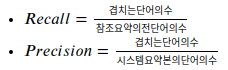
- 정확한 모델 성능 평가를 위해 Precision과 Recall을 모두 계산한 후, F-Measure를 측정하는 것이 바람직

참고자료: [F-Measure-Precision과 Recall을 통합한 정확도 측정](https://blog.acronym.co.kr/557)     
[Week 14 - 숫자만 잘 세도 NLP 모델이 된다? N-gram language model](https://jiho-ml.com/weekly-nlp-14/)

- $F1 Measure=2\frac{precision*recall}{precision+recall}$
F1 Measure는 Precision과 Recall의 중요성을 동일하게 보며 자주 사용하는 F-Measure 값이다.

In [67]:
from PyRouge.pyrouge import Rouge

r = Rouge()

system_generated_summary = ['killed injured in fire at hotel in china']
manual_summmary = ['killed in fire at hotel in china']     

[precision, recall, f_score] = r.rouge_l([system_generated_summary][i], [manual_summmary][i])

print("Precision is :"+str(precision)+"\nRecall is :"+str(recall)+"\nF Score is :"+str(f_score))

ModuleNotFoundError: No module named 'PyRouge'

for문으로 고치려고 시도했는데, 맞게 한 건지는 모르겠다. 

In [67]:
from PyRouge.pyrouge import Rouge

r = Rouge()
precision = []
recall = []
f_score = []

system_generated_summary = ['killed injured in fire at hotel in china', 'azam khan claims army khan to armed forces', 'car crashes into car to be stolen from us car', 'mayweather offers lakh to buy cryptocurrency for lakh', 'taliban to afghanistan afghanistan']
manual_summmary = ['killed in fire at hotel in china', 'sp leader azam khan to be for anti army remark', 'driverless car in virginia driven by man hidden in car seat', 'mayweather mcgregor fight tickets being sold for lakh', 'taliban increasing control over afghan territory us monitor']     
for i in range(len(system_generated_summary)):
    [precision[i], recall[i], f_score[i]] = r.rouge_l([system_generated_summary][i], [manual_summmary][i])
    precision.append(precision[i])
    recall.append(precision[i])
    f_score.append(precision[i])
    print("Precision is :"+str(precision[i])+"\nRecall is :"+str(recall[i])+"\nF Score is :"+str(f_score[i]))

ModuleNotFoundError: No module named 'PyRouge'

그래서 직접 계산해 보기로 했다. 

|번호|실제요약|모델요약|겹치는 단어수|Precision|Recall|F-Measure|
|---|:----------:|:---------:|:---------:|:------:|:----:|:------:|
|55 |7  |  8|7 |0.88| 1 | 0.93|  
|65 |10 |  8|2 |0.25 |0.2 |0.045|  
|75 |11 | 10|2 |0.2 |0.18 |0.027|   
|85 |8  |  8|3 |0.38 |0.38|0.21 | 
|95 |8  |  4|1 |0.25|0.13|0.17 |  

### 실제 요약과 추출적 예측의 비교
ratio=0.4로 했을 때 추출적 예측 문장이 나오지 않는 경우가 50개 중 10개가 있었다. 왜 그렇게 되는지 그 이유를 잘 모르겠다. 추상적 요약의 경우처럼 5개의 샘플을 뽑아 비교하였다. 

60
원문 : Banned cricketer Sreesanth has told Supreme Court he initially confessed to Delhi Police about his alleged involvement in 2013 IPL spot-fixing scandal to escape continuous police torture. Sreesanth further said the bookie tried dragging him into spot-fixing but he didn't fall for it. Citing Sreesanth not informing BCCI about fixing approach, the apex court said Sreesanth's conduct "wasn't good".

실제 요약 : Confessed to spot-fixing to escape police torture: Sreesanth to SC        
추출적 예측 요약 : Sreesanth further said the bookie tried dragging him into spot-fixing but he didn't fall for it.  

69
원문 : Yami Gautam was felicitated by Border Security Force (BSF) in Amritsar for her performance in 'Uri: The Surgical Strike'. "BSF is the first line of defence of our country and it gives me...pride to have met them," Yami said. The film, which also stars Vicky Kaushal, is based on the Indian Army's surgical strike operation which took place in 2016.

실제 요약 : Yami Gautam felicitated by BSF for performance in 'Uri...'

추출적 예측 요약 : Yami Gautam was felicitated by Border Security Force (BSF) in Amritsar for her performance in 'Uri: The Surgical Strike'.

80
원문 : Jet Airways on Wednesday denied it was directed by GE Capital Aviation Services to ground its aircraft due to non-payment of dues. The airline said it's in the process of delivering three aircraft to lessors due to the expiry of lease terms. Further, three aircraft have been temporarily grounded to carry out an engine normalisation exercise, it added.

실제 요약 : Jet Airways denies being told to ground aircraft          
추출적 예측 요약 : Further, three aircraft have been temporarily grounded to carry out an engine normalisation exercise, it added.

90
원문 : Tamil Nadu food safety officials on Wednesday raided and seized 1,000 kgs of banned plastic items from Hotel Saravana Bhavan in Chennai's Vadapalani. Officials began a surprise check in the branch at 8 am. The state government had banned single-use plastics from January 1 and said the banned items should be handed over at the offices of the city corporation.     
실제 요약 : 1,000 kg banned plastic seized from Saravana Bhavan in Chennai       
추출적 예측 요약 : Tamil Nadu food safety officials on Wednesday raided and seized 1,000 kgs of banned plastic items from Hotel Saravana Bhavan in Chennai's Vadapalani.    

100
원문 : Prime Minister Narendra Modi on Wednesday said his government's demonetisation decision made houses affordable for the aspiring youth. He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector". He said 'UDAN' (Ude Desh ka Aam Nagrik) scheme has boosted the development of the country's aviation sector.    
실제 요약 : Demonetisation made homes affordable for youth: PM Modi

추출적 예측 요약 : He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".    

추출적 예측 문장은 원문의 문장을 그대로 갖다 쓰는 경우가 많기 때문에 문법적으로는 별 문제가 없다. 때로 69, 90번과 같이 핵심 문장을 가져다 쓰는 경우도 있지만 60, 80, 100과 같이 중요하지 않은 문장을 가져오는 경우도 있다. 

|번호|실제요약|모델요약|겹치는 단어수|Precision|Recall|F-Measure|
|---|:----------:|:---------:|:---------:|:------:|:----:|:------:|
|55 |10  |  16|1 |0.063| 0.1 | 0.078|  
|65 |9 |  19|7 |0.37 |0.78 |0.66|  
|75 |8 | 16|1 |0.063 |0.125 |0.003|   
|85 |10  |  23|9 |0.39 |0.9|0.54 |
|95 |8  |  24|1 |0.042|0.125|0.002 |  


## 정리
추상적 예측과 추출적 예측을 비교해 보았을 때, 1) __문법__ 적으로는 원문의 문장을 그대로 가져다 쓰는 추출적 예측이 더 정확하다. 그러나 2) __핵심 단어__ 의 측면에서 보면 추상적 예측이 핵심 단어를 조금 더 많이 포함한다. 추출적 예측의 경우, 핵심 문장이 아닌 다른 문장을 가져오는 경우, 핵심 단어가 하나도 포함되지 않는 경우가 생기기 때문이다. 반면 추상적 예측의 경우는 원문을 요약한 문장을 학습하고 그로부터 새로운 문장을 생성하기 때문에 핵심 단어를 포함하고 있는 경우가 더 많다. 3) __문장 해석__ 의 측면에서 보면 추상적 예측은 원문과 제공된 요약문을 학습하여 직접 문장을 생성한 것이기 때문에 말이 되지 않는 문장이 많다. 그러나 추출적 예측의 경우는 문장을 그대로 가져다 쓰는 것이기 때문에 해석은 가능하다. 

정리하자면 추상적 예측의 경우는 추출적 예측보다 핵심 단어를 더 많이 포함하고, 문법과 해석의 측면에서는 성능이 추출적 예측보다는 떨어진다. 만약 추상적 예측 모델의 성능이 더 좋아진다면 문법과 해석적인 면에서도 좋은 성과를 얻을 것으로 기대한다. 

Rouge 성능지표는 위의 해석을 증명해준다. 추출적 요약의 경우, 핵심문장을 추출한 경우, 성능이 좋지만 그렇지 않은 경우는 성능이 매우 안 좋은 것을 볼 수 있다. 반면 추상적 요약은 F-Measure가 비슷한 수준으로 나온다. 이는 모델의 성능에 따라 비슷한 수준으로 요약한다는 의미 같다.  

## 루브릭
|평가문항|	상세기준|결과|
|:------:|:--------:|:---:|
|1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.|분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.|Y     |
|2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.|모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.|Y    |
|3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.|두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.| Y    |

## 후기
### 이번 프로젝트에서 어려웠던 점
- 기본 개념을 이해하는 것이 어려워서 여러 자료를 찾고서야 조금 이해했다. 
- 전처리를 할 때, 중복 샘플을 어떻게 처리할 것인가에서 고민을 했다. 중복된 기사를 직접 보고 결정하고자 하였으나 잘 안 되었다. 
- 모델 학습이 오래 걸려서 전처리를 어떻게 하느냐에 따라 결과가 바뀌는지 보고 싶었는데, 그러지 못해 아쉽다. 

### 프로젝트를 진행하면서 알게된 점
- seq2seq, attention 모델의 기본 개념에 대해 조금 파악하였다. 
- 요약 모델의 성능 지표가 있다는 것을 알게 되었다. 

### 프로젝트를 진행하면서 아직 모호한 점
- 전처리를 하는 방법이 아직 모호하다. 전처리 방법에 따라서 달라질 것 같은데, 이 부분은 언어에 대한 깊은 이해가 있어야 할 것 같다.  
- 요약 모델을 만드는 코드에 대한 이해가 더 필요하다. 

### 자기 다짐
어려웠지만 재미있었던 프로젝트였다. 모델을 학습시켜 요약이 나온다는 것이 신기하기도 했다. 시간에 오래 걸려 다양하게 전처리 과정을 시도하지 못해 아쉬웠다. 슬랙에 올라온 요약 모델의 Rouge 성능 지표를 코드로 구현해보려고 하였으나 관련 패키지가 설치되지 않아 시도하지 못했다. 다음에 기회가 되면 더 공부해 보고 싶다. 